## Sequence

### BPcal
 - solve G 
 - solve B; using G

### PMcal
 - solve G; using B
 
### FDcal
 - solve G; using B
 - scale 

In [ ]:
# bandpass calibrator
# scan = 3

set_model(visfile, scans, modeltype='bandpass')
gaincal(visfile, scan=scans, caltable='bp_init.G' gaintype='G')
bandpass(visfile, scan=scans, caltable='bp_init.B', gaintype='B', gaintable='bp_init.G')



In [ ]:
from collections import defaultdict
from casatasks import tclean, split, listobs, plotants, imstat, clearcal, visstat, casalog, flagdata
from casatasks import uvcontsub, flagdata, gencal, plotweather, setjy, gaincal, bandpass, applycal, fluxscale, importgmrt
from casaviewer import imview
from casaplotms import plotms
from pathlib import Path
from casatools import image as IA
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
import io
import base64
from os import path, makedirs, remove, getcwd
import glob
from shutil import rmtree
from matplotlib import rcParams, rc
import os
from casatools import ms, msmetadata

# casalog.filter('DEBUG1')
msmd = msmetadata()


from casatools import image as IA
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


def __clear_tmp(wd,filename):
    filelist = glob.glob(path.join(wd, filename+'*'))
    for f in filelist:
        try:
            rmtree(f)
        except OSError:
            remove(f)
def save_fig(plt, fig, kind='base64', output='output.jpg'):
    if kind == 'base64':
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight',
                    transparent=True, pad_inches=0)
        buf.seek(0)
        string = base64.b64encode(buf.read())
        plt.close()
        return string
    elif kind == 'plot':
        plt.show()
        return 'plotted'
    else :
        if not path.exists('output'):
            makedirs('output')
        newPath = 'output/'+output
        opt = newPath
        if path.exists(newPath):
            numb = 1
            while path.exists(newPath):
                newPath = "{0}_{2}{1}".format(
                    *path.splitext(opt) + (numb,))
                try :
                    if path.exists(newPath):
                        numb += 1 
                except:
                    pass               
        fig.savefig(newPath, format=kind, bbox_inches='tight',
                    pad_inches=0)
        print("saved {}".format(newPath))
        plt.close()
        return newPath
def fetch_sources(vis):
    """
    fetch calibrator and target sources from the measurement set and return dictionary
    """
    pmcalf = '0'
    pmcals = '1'

    bpcalf = '0'
    bpcals = '3'

    fdcalf = '0'
    fdcals = '1'

    targets = '2'
    targetf = '1'

    return {'pmcalf':pmcalf, 'pmcals':pmcals, 
            'bpcalf':bpcalf, 'bpcals':bpcals,
           'fdcalf':fdcalf, 'fdcals':fdcals,
           'targetf':targetf, 'targets':targets
           }



def bandpass_fc(csource, suffix='_init',ref_ant='C00', plotfolder='bp_plots/',fspw = '0:101~1900', 
                outvis='', **kwargs):
    cwd = getcwd()
    if not path.exists(plotfolder):
        try:
            oumask = os.umask(0)
            makedirs(plotfolder)
        finally:
            os.umask(oumask)
#             makedirs(plotfolder, 777)
            
    params={'reset':False, 
            'quackinterval':10.0, 
            'quackmode':'beg', 'bad_antenna':'',
                   }
#     params = defaultdict(lambda: -1, def_params)
    params.update(kwargs)
    if kwargs:
        for k in kwargs:
            if k in params.keys():
                params[k]=kwargs[k]
    if params['reset']:
        flagdata(vis=csource,mode='unflag', field='', spw='', antenna='', timerange='')
        clearcal(vis=csource)

    #### initialize ###########################
    s=fetch_sources(csource)
    
    csource_stem = Path(csource).stem

    ########## bandpass flagging ##############
    
#     plotms(vis=csource, scan=s['bpcals'], antenna=ref_ant, xaxis='freq', iteraxis='scan', yaxis='amp',
#        ydatacolumn='data', plotfile=plotfolder+'amp_v_freq_before_begin.png', title='Before Flagging',
#        coloraxis='baseline',showgui=False)
    flagdata(vis=csource, mode='clip', clipzeros=True, flagbackup=False, action='apply') # clip zero amplitude
    flagdata(vis=csource, mode='shadow', tolerance=0.0, flagbackup=False, action='apply') # shadowing
    flagdata(vis=csource, mode='quack', quackinterval=params['quackinterval'], quackmode=params['quackmode'], 
             flagbackup=False, action='apply')
    flagdata(vis=csource, mode='tfcrop', spw='0', scan='3', datacolumn='data', action='apply', 
             flagbackup=True)
    if params['bad_antenna']:
        flagdata(vis=csource, antenna=params['bad_antenna'],action='apply')

    ###### initial bandpass ##########
    csource_flagged = outvis or csource_stem+f'_scan{s["bpcals"]}_flagged.MS'
    bptab={}
    bptab['Ph_init'], bptab['BP_init']='bp_ph.initPh', 'bp_BP.initBP'
    
    os.system(f'rm -rf {bptab["Ph_init"]} {bptab["BP_init"]}')
    gaincal(vis=csource, caltable=bptab['Ph_init'], 
            selectdata=True, scan=s['bpcals'],
            solint=' int ', spw=fspw, refant=ref_ant, minblperant=3, 
            minsnr=3.0, calmode='p')
#     plotms(vis=bptab['Ph_init'], xaxis='time', yaxis='phase', plotfile=plotfolder+'ph_time_ph_init.png', 
#            showgui=False, iteraxis='spw', antenna=ref_ant, coloraxis='Antenna1')
    bandpass(vis=csource, caltable=bptab['BP_init'],
            field=s['bpcalf'], 
            solint=' inf ', combine='scan', refant=ref_ant, 
            minblperant=3, minsnr=10.0, gaintable=bptab['Ph_init'],
    #          selectdata=True, scan=bpcals,
            interp='nearest', solnorm=False)
#     plotms(vis=bptab["BP_init"],xaxis='freq', yaxis='amp',ydatacolumn='corrected', antenna=ref_ant, 
#         showgui=False, plotfile=plotfolder+f'freq_amp_bp_init_{ref_ant}.png',
#             coloraxis='corr',gridrows=2)
    applycal(vis=csource, gaintable=bptab['BP_init'], calwt=False)
    
    flagdata(vis=csource, mode='rflag', spw='0', datacolumn='corrected', scan=s['bpcals'],
            freqdevscale=2.5, timedevscale=3.5, extendflags=True, action='apply', 
    #          display='both', 
            timeavg=True , flagbackup=True
            )
    flagdata(csource, mode='extend', growfreq=80.0, growtime=60.0, action='apply', extendpols=True)
    print(f'splitting ms....{csource_flagged}')
    split(csource,csource_flagged)
    
    


def dical(csource, suffix='_init', ref_ant='C00', gspw='0:201~1800', field='0',):
    
    
    #### initialize ###########################
    s=fetch_sources(csource)
    csource_stem = Path(csource).stem

    gtab={}
    gtab['delay']=csource_stem+'.K'+suffix
    gtab['bph']=csource_stem+'.P.G'+suffix
    gtab['bp']=csource_stem+'.B'+suffix
    gtab['intph']=csource_stem+'.IP.G'+suffix
    gtab['scnph']=csource_stem+'.SP.G'+suffix
    gtab['amp']=csource_stem+'.A.G'+suffix
    
    os.system(f'rm -rf {gtab["delay"]}')
    gaincal(vis=csource, caltable=gtab['delay'], 
            field=field, 
            selectdata=True, scan=s['pmcals'], 
            solint='inf', refant=ref_ant, gaintype='K')

    os.system(f'rm -rf {gtab["bph"]}')
    gaincal(vis=csource, caltable=gtab['bph'], 
            field=field, 
            spw=gspw, refant=ref_ant, 
            calmode='p', solint='int', 
            minsnr=3.0, gaintype='G', 
            gaintable=[gtab['delay']])

    os.system(f'rm -rf {gtab["bp"]}')
    bandpass(vis=csource, 
             caltable=gtab["bp"], 
             spw ='0',
             field=field,
             solint='inf', 
             refant=ref_ant, 
             solnorm = True,bandtype='B', gaintable=[gtab['bph'], gtab['delay']],
        minsnr=3.0, fillgaps=8, parang = True, 
             interp=['nearest,nearestflag','nearest,nearestflag'])

    # to fix Amp vs time
    os.system(f'rm -rf {gtab["intph"]}')
    gaincal(vis=csource,
            caltable=gtab["intph"], 
            field=field, 
            spw='0', 
            refant=ref_ant, 
            calmode='p', 
            solint='int', 
            minsnr=3.0, 
            gaintable=[gtab['bph'], gtab['delay']]
           )

    # no enough for interpolating the phase solutions in time
    os.system(f'rm -rf {gtab["scnph"]}')
    gaincal(vis=csource, 
            caltable=gtab['scnph'], 
            field=field, 
            spw='0', 
            refant=ref_ant, 
            calmode='p', 
            solint='inf', 
            combine='', 
            minsnr=3.0, 
            gaintable=[gtab['bph'], gtab['delay']]
           )

    # scaling amplitude gains skipping fluxscale as our flux-calibrator is also our 
    # bandpass and gain calibrator, the absolute flux scale will already be ok
    os.system(f'rm -rf {gtab["amp"]}')
    gaincal(vis=csource, 
            caltable=gtab['amp'], 
            field=field, 
            spw='0', selectdata=False, solint='inf', combine='', refant=ref_ant,
            calmode='ap', minsnr=3.0, 
            gaintable=[gtab['bph'], gtab['delay'], gtab['intph']])
    applycal(
        vis=csource, 
        field=s['bpcalf'], 
        gaintable=[gtab['delay'],gtab['bp'],gtab['scnph'],gtab['amp']], 
        gainfield=[s['bpcalf'],s['bpcalf'],s['bpcalf'],s['bpcalf']], 
        parang=True, calwt=False, applymode='calflagstrict', flagbackup=True)

    applycal(
        vis=csource, 
        field=s['targetf'], 
        gaintable=[gtab['delay'],gtab['bp'],gtab['scnph'],gtab['amp']], 
        gainfield=[s['bpcalf'],s['bpcalf'],s['bpcalf'],s['bpcalf']],
        calwt=False, applymode='calflagstrict', flagbackup=True)
    return {'tables':gtab}

def all_cal(csource, suffix='_init',ref_ant='C00', plotfolder='simplots/',fspw = '0:101~1900', 
                outvis='', **kwargs):
    cwd = getcwd()
    if not path.exists(plotfolder):
        try:
            oumask = os.umask(0)
            makedirs(plotfolder)
        finally:
            os.umask(oumask)
#             makedirs(plotfolder, 777)
            
    params={'reset':False, 
            
                   }
#     params = defaultdict(lambda: -1, def_params)
    params.update(kwargs)
    if kwargs:
        for k in kwargs:
            if k in params.keys():
                params[k]=kwargs[k]
    if params['reset']:
        flagdata(vis=csource,mode='unflag', field='', spw='', antenna='', timerange='')
        clearcal(vis=csource)

    #### initialize ###########################
    s=fetch_sources(csource)
    csource_stem = Path(csource).stem
    calibrated_csource=outvis or csource_stem+suffix+'.MS'

    ########## bandpass calibrator calibration ##############
    setjy(vis=csource, field=s['bpcalf'], 
          scan=s['bpcals'], 
          scalebychan=True, standard='Perley-Butler 2017', 
          listmodels=False, usescratch=True)
    tab_init = dical(csource, '_init')
    # tab_recal= dical(csource, '_recal')
    split(csource,calibrated_csource)
    

def selfcal_model(calibrated_target, goodchans='0:500~600', ref_ant='C00'):
    ctarget_stem = str(Path(calibrated_target).stem)

    sctarget={}
    sctarget['sc1']=ctarget_stem+'.model1.MS'
    sctarget['sc2']=ctarget_stem+'.model2.MS'
    sctarget['sc3']=ctarget_stem+'.model3.MS'

    sgtab={}
    sgtab['sc1']='sc1.gcal'
    sgtab['sc2']='sc2.gcal'
    sgtab['sc3']='sc3.gcal'
    
    tclean(vis=calibrated_target, 
           datacolumn='data', 
           imagename=ctarget_stem+'.model.cimage', 
           spw=goodchans, 
           specmode='mfs', 
           niter=100, 
           threshold='1.5Jy', 
           imsize=[256,256], cell='1arcsec', 
           weighting='briggs', robust=0.2, 
           savemodel='modelcolumn')
    gaincal(vis=calibrated_target, 
            caltable=sgtab['sc1'], 
            field='0', spw='0', refant=ref_ant, calmode='p', solint='60s', combine='', 
            minsnr=3.0)
    applycal(vis=calibrated_target, field='0', gaintable=[sgtab['sc1']], interp='linear')
    split(vis=calibrated_target, outputvis=sctarget['sc1'], datacolumn='corrected', 
          field='0', keepflags=False)

    tclean(vis=sctarget['sc1'], datacolumn='data', 
           imagename=sctarget['sc1']+'.cimage', 
           spw=goodchans, 
           specmode='mfs', 
           niter=500, 
           threshold='500mJy', 
           imsize=[256,256],cell='1arcsec', 
           weighting='briggs', robust=0.2, 
           savemodel='modelcolumn')
    gaincal(vis=sctarget['sc1'], caltable=sgtab['sc2'], 
            field='0', spw='0', refant=ref_ant, calmode='p', solint='30s', combine='', 
            minsnr=3.0)
    applycal(vis=sctarget['sc1'], field='0', gaintable=[sgtab['sc2']], interp='linear')
    split(vis=sctarget['sc1'], outputvis=sctarget['sc2'], datacolumn='corrected', 
          field='0', keepflags=False)

    tclean(vis=sctarget['sc2'], datacolumn='data', 
           imagename=sctarget['sc2']+'.cimage', spw=goodchans, 
           specmode='mfs', 
           niter=1000, threshold='100mJy', 
           imsize=[256,256], cell='1arcsec', weighting='briggs', robust=0.2, 
           savemodel='modelcolumn')
    gaincal(vis=sctarget['sc2'], caltable=sgtab['sc3'], 
            field='0', spw='0', refant=ref_ant, calmode='ap', solint='30s', combine='', 
            minsnr=3.0)
    applycal(vis=sctarget['sc2'], field='0', gaintable=[sgtab['sc3']], interp='linear')
    
    os.system(f'rm -rf {sctarget["sc3"]}.*')
    split(vis=sctarget['sc2'], outputvis=sctarget['sc3'], datacolumn='corrected', 
          field='0', keepflags=False)

    tclean(vis=sctarget['sc3'], datacolumn='data', 
           imagename=sctarget['sc3']+'.cimage', spw=goodchans, 
           specmode='mfs', 
           niter=1000, threshold='100mJy', 
           imsize=[256,256], cell='1arcsec', weighting='briggs', robust=0.2, 
           savemodel='modelcolumn')
    return {'model_imagename':sctarget['sc3']+'.cimage', 'model_vis':sctarget['sc3']}
def fetch_sources(vis):
    """
    fetch calibrator and target sources from the measurement set and return dictionary
    """
    pmcalf = '0'
    pmcals = '1'

    bpcalf = '0'
    bpcals = '3'

    fdcalf = '0'
    fdcals = '1'

    targets = '2'
    targetf = '1'

    return {'pmcalf':pmcalf, 'pmcals':pmcals, 
            'bpcalf':bpcalf, 'bpcals':bpcals,
           'fdcalf':fdcalf, 'fdcals':fdcals,
           'targetf':targetf, 'targets':targets
           }


def genpng(cimg, chno=0, out='output.jpg', norm_max=None, **kwargs):
    ia = IA()
    ia.open(cimg)
    pix = ia.getchunk()[:,:,0,chno]
    csys = ia.coordsys()
    ia.close()
    
    rad_to_deg =  180/np.pi
    w = WCS(naxis=2)
    w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
    w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
    w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
    w.wcs.ctype = ['RA---SIN', 'DEC--SIN']
    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot(1, 1, 1, projection=w)
#     p1 = int(pix.shape[0]*0.25)
#     p2 = int(pix.shape[0]*0.75)

#     im = ax.imshow(pix[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
    if norm_max:
        try:
            norm_max=float(norm_max)
            im = ax.imshow(pix.transpose(), origin='lower',  
                           cmap=plt.cm.gist_heat, interpolation="none",
                           norm=colors.CenteredNorm(0.0,norm_max))
        except:
            im = ax.imshow(pix.transpose(), origin='lower',  
                           cmap=plt.cm.gist_heat, interpolation="none",
                           norm=colors.CenteredNorm(0.0))
        
    else:
        im = ax.imshow(pix.transpose(), origin='lower',  
                       cmap=plt.cm.gist_heat, interpolation="none",
                       norm=colors.CenteredNorm(0.0))
        
    plt.colorbar(im, ax=ax)
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    ax.set_title(str(out))
#     ax.add_size_bar(1/3600./f_hst[0].header["cdelt2"],
#                      r"$1^{\prime\prime}$", loc=3,
#                      borderpad=0.2)
    scalebar = AnchoredSizeBar(ax.transData,
                           5, r"$5^{\prime\prime}$", 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1, borderpad=0.5, sep=5,
#                            fontproperties=fontprops
                   )
    ax.add_artist(scalebar)
    kind = kwargs['kind'] or 'jpg'
    save_fig(plt, fig, kind, output=out+'.jpg')
    

def tclean_spectral_image(vis, imagename, rest_freq, suffix='', norm_max=None):
    os.system(f'rm -rf {imagename}.*')
    tclean(vis=vis, datacolumn='data', 
           imagename=imagename, spw=f'0:{rest_freq}',
           specmode='cube', outframe='bary', veltype='optical', restfreq=rest_freq, 
           niter=10000000, threshold='0.05Jy',
           imsize=[256,256], cell='1arcsec', 
           pbcor=True, weighting='briggs', robust=0.2, 
           perchanweightdensity=True, savemodel='none',
           interpolation='nearest')
    
    genpng(imagename+'.image',0,out=f"{imagename}"+suffix+'.bary.cube.1', norm_max=norm_max, kind='jpg')
    genpng(imagename+'.image',1,out=f"{imagename}"+suffix+'.bary.cube.1', norm_max=norm_max, kind='jpg')
#     imview(raster={'file':f"{imagename}"+'.image', 'colormap': 'Hot Metal 1'}, 
#        zoom={'channel': 0, },
#        axes={'z':'Frequency',},
#         out=f"{imagename}"+suffix+'.bary.cube.1'+'.png',       
#       )
#     imview(raster={'file':f"{imagename}"+'.image', 'colormap': 'Hot Metal 1'}, 
#            zoom={'channel': 1, },
#            axes={'z':'Frequency',},
#             out=f"{imagename}"+suffix+'.bary.cube.2'+'.png',
#           )

def tclean_continuum_image(science_vis_cont, imagename, suffix='', norm_max=None):
    os.system(f'rm -rf {imagename} {imagename}.*')
    tclean(vis=science_vis_cont, datacolumn='data', 
       imagename=imagename, spw='0', 
       specmode='mfs', 
       niter=1000, threshold='50mJy', 
       imsize=[256,256], cell='1arcsec', weighting='briggs', robust=0.2, 
#        savemodel='modelcolumn'
      )
    if norm_max is None:
        norm_max=imstat(imagename+'.image')['max'][0]
    genpng(imagename+'.image',0,out=f"{imagename}"+suffix+'.cont', norm_max=norm_max, kind='jpg')
    return norm_max
#     imview(raster={'file':f"{imagename}"+'.image', 'colormap': 'Hot Metal 1'}, 
#             out=f"{imagename}"+suffix+'.cont'+'.png',

#           )



def fast_spectral_image(calvis, cvis, timerange,rest_freq , suffix):
    os.system(f'rm -rf {cvis}')
    split(calvis, cvis, timerange=timerange, datacolumn='data')
    uvcontsub(cvis, field='0',
          fitspw=f'0:{rest_freq}', excludechans=True,
          fitorder=1,
          want_cont=True,
         )
    science_vis=cvis+'.contsub'
    science_vis_cont=cvis+'.cont'
    norm_max=tclean_continuum_image(science_vis_cont, science_vis_cont+'.cimage', suffix=suffix+'.cont')
    tclean_spectral_image(science_vis, science_vis+'.cimage', rest_freq, suffix=suffix+'.cube', norm_max=norm_max)
    


def selfcal_all(calibrated_csource, ):
    s=s=fetch_sources(calibrated_csource)
    ctarget_stem = Path(calibrated_csource).stem
    calibrated_target=ctarget_stem+f'_field{s["targetf"]}.MS'
    rest_freq = '599.934021MHz'

    split(calibrated_csource, calibrated_target, datacolumn='data', field=s['targetf'])
    model_dict=selfcal_model(calibrated_target)
    t_duration = 12 # total time duration (seconds)
    t_step = 12 # t_step seconds for imaging as time step in between the total duration
    sctarget={}
    sctarget['sc3'],sctarget['sc3_t']= model_dict['model_vis'], model_dict['model_vis']+'_spectral_image'
    
    for i in range(5,t_duration,t_step): # 
        k1 =i
        k2 =k1+t_step
        sctarget['sc3_tk']=sctarget['sc3_t']+f'{k1}_{k2}.MS'
        timerange=f'15:04:{k1:02d}.8~15:04:{k2:02d}.8'
        print(timerange)    
        print(sctarget['sc3_tk'])
        try:
            fast_spectral_image(sctarget['sc3'], sctarget['sc3_tk'], str(timerange), rest_freq , suffix=f'{k2}')
        except Exception as e:
            print(f'{e}')
            pass
    tclean_continuum_image(model_dict['model_vis'], 'whole_continuum', '_contonly')
    
# kwargs={'bad_antenna':'C03,C08,C09,C10,C11,C14,C06',
#        'quackmode':'beg', 'quackinterval':5.0, 'reset':False}
# ucsource='/home/avi/CASA/imaging/data/TEST2505_B0329_100MHZ_GWB_2.MS'
# ocsource='test2505_pipeline_bp.MS'
# ocsource_cal='test2505_pipeline_bp_allcal.MS'
# bandpass_fc(ucsource, outvis=ocsource, **kwargs)
# # kwargs={'reset':True}
# all_cal(ocsource, outvis=ocsource_cal, )
# selfcal_all(ocsource_cal)

# Calibration and flagging

In [6]:
def __clear_tmp(wd,cimagename):
    filelist = glob.glob(path.join(wd, cimagename+'*'))
    for f in filelist:
        try:
            rmtree(f)
        except OSError:
            remove(f)

from pyvirtualdisplay import Display
display = Display(visible=0,size=(1024,768))
display.start( )

print('completed system setup')
ocsource='test2505_pipeline_bp.MS'
ucsource='/home/avi/CASA/imaging/data/TEST2505_B0329_100MHZ_GWB_2.MS'
# split(vis=ucsource, outputvis=ocsource, datacolumn='data')   
plotms(vis=ucsource, 
      xaxis='phase', yaxis='amp', avgtime='8', field='0', antenna='C00', coloraxis='baseline', showgui=False, 
      plotfile='ph_amp_noflag.jpg', overwrite=True)

You should consider upgrading via the '/home/avi/CASA/casadev/bin/python3.8 -m pip install --upgrade pip' command.


completed system setup


Qt: Session management error: None of the authentication protocols specified are supported


NOTICE: Exporting to images in screen resolution is currently not working.  Switching to high resolution (which is slower, but works).


In [8]:
flagdata(vis=ucsource,mode='unflag', field='', spw='', antenna='', timerange='')
clearcal(vis=ucsource)

2022-03-11 05:52:25	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


# init flag

- badchan
- badant
- clip at 50Jy
- tfcrop indep on primary cal and secondary cal and target

In [5]:
cwd = getcwd()
def init_flag(csource, **kwargs):
    
    params={'reset':False, 
            'quackinterval':10.0, 
            'quackmode':'beg', 'badant':'', 'badchan':'','clip':[0,50],'refant':'C00',
                   }
#     params = defaultdict(lambda: -1, def_params)
    params.update(kwargs)
    if kwargs:
        for k in kwargs:
            if k in params.keys():
                params[k]=kwargs[k]
    if params['reset']:
        flagdata(vis=csource,mode='unflag', field='', spw='', antenna='', timerange='')
        clearcal(vis=csource)

    #### initialize ###########################
    s=fetch_sources(csource)
    print(params)
    csource_stem = Path(csource).stem
#     flagdata(vis=csource, mode='clip', clipzeros=True, flagbackup=False, action='apply') # clip zero amplitude
#     flagdata(vis=csource, mode='shadow', tolerance=0.0, flagbackup=False, action='apply') # shadowing
#     flagdata(vis=csource, mode='quack', quackinterval=params['quackinterval'], quackmode=params['quackmode'], 
#              flagbackup=False, action='apply')
#     flagdata(vis=csource, mode='clip', clipminmax=params['clip'], flagbackup=False, action='apply')
#     if params['badant']: flagdata(vis=csource, antenna=params['badant'],action='apply')
# #     flagdata(vis=csource, mode='tfcrop', flagbackup=True, action='apply', extendpols=True, extendflags=True)
#     if params['refant']: plotms(vis=csource, xaxis='freq', yaxis='amp', avgtime='8', field='0', antenna=params['refant'], coloraxis='baseline', showgui=False, plotfile='freq_amp_flagged.jpg')
kwargs={}
kwargs['badant']='C03,C08,C09,C10,C11,C14,C06'
init_flag(ucsource, **kwargs)

{'reset': False, 'quackinterval': 10.0, 'quackmode': 'beg', 'badant': 'C03,C08,C09,C10,C11,C14,C06', 'badchan': '', 'clip': [0, 50], 'refant': 'C00'}


# Setting model

In [13]:

def reflag(csource, suffix='_reflag', outvis='', fspw = '0:101~1900', ref_ant='C00' ):
    s=fetch_sources(csource)
    print(f'tfcrop indipendent on each source :')
    print(f'source:{s["bpcals"]}')
    flagdata(vis=csource, mode='tfcrop', flagbackup=True, action='apply', extendpols=True, extendflags=True, 
            scan=s['bpcals'])
    print(f'source:{s["pmcals"]}')
    flagdata(vis=csource, mode='tfcrop', flagbackup=True, action='apply', extendpols=True, extendflags=True, 
            scan=s['pmcals'])
    print(f'source:{s["targets"]}')
    flagdata(vis=csource, mode='tfcrop', flagbackup=True, action='apply', extendpols=True, extendflags=True, 
            scan=s['targets'])
    print(f'rflag indipendent on each source :')
    print(f'source:{s["bpcals"]}')
    
    csource_stem = Path(csource).stem
    ###### initial bandpass ##########
    csource_flagged = outvis or csource_stem+f'_scan{s["bpcals"]}_flagged.MS'
    bptab={}
    bptab['Ph_init'], bptab['BP_init']='bp_ph.initPh', 'bp_BP.initBP'
    
    os.system(f'rm -rf {bptab["Ph_init"]} {bptab["BP_init"]}')
    gaincal(vis=csource, caltable=bptab['Ph_init'], 
            selectdata=True, scan=s['bpcals'],
            solint=' int ', spw=fspw, refant=ref_ant, minblperant=3, 
            minsnr=3.0, calmode='p')
#     plotms(vis=bptab['Ph_init'], xaxis='time', yaxis='phase', plotfile=plotfolder+'ph_time_ph_init.png', 
#            showgui=False, iteraxis='spw', antenna=ref_ant, coloraxis='Antenna1')
    bandpass(vis=csource, caltable=bptab['BP_init'],
            field=s['bpcalf'], 
            solint=' inf ', combine='scan', refant=ref_ant, 
            minblperant=3, minsnr=10.0, gaintable=bptab['Ph_init'],
    #          selectdata=True, scan=bpcals,
            interp='nearest', solnorm=False)
#     plotms(vis=bptab["BP_init"],xaxis='freq', yaxis='amp',ydatacolumn='corrected', antenna=ref_ant, 
#         showgui=False, plotfile=plotfolder+f'freq_amp_bp_init_{ref_ant}.png',
#             coloraxis='corr',gridrows=2)
    applycal(vis=csource, gaintable=bptab['BP_init'], calwt=False)
    flagdata(vis=csource, mode='rflag', spw='0', datacolumn='corrected', scan=s['bpcals'],
            freqdevscale=2.5, timedevscale=3.5, extendflags=True, action='apply', 
            timeavg=True , flagbackup=True
            )
    flagdata(csource, mode='extend', growfreq=80.0, growtime=60.0, action='apply', extendpols=True)
    print(f'splitting ms....{csource_flagged}')
    split(csource,csource_flagged)
    
def all_cal(csource, suffix='_init',ref_ant='C00', plotfolder='simplots/',fspw = '0:101~1900', 
                outvis='', **kwargs):
    cwd = getcwd()
    if not path.exists(plotfolder):
        try:
            oumask = os.umask(0)
            makedirs(plotfolder)
        finally:
            os.umask(oumask)
#             makedirs(plotfolder, 777)
    params={'reset':False, 
                   }
#     params = defaultdict(lambda: -1, def_params)
    params.update(kwargs)
    if kwargs:
        for k in kwargs:
            if k in params.keys():
                params[k]=kwargs[k]
    if params['reset']:
        flagdata(vis=csource,mode='unflag', field='', spw='', antenna='', timerange='')
        clearcal(vis=csource)

    #### initialize ###########################
    s=fetch_sources(csource)
    csource_stem = Path(csource).stem
    calibrated_csource=outvis or csource_stem+suffix+'.MS'

    ########## bandpass calibrator calibration ##############
    setjy(vis=csource, field=s['bpcalf'], scan=s['bpcals'], scalebychan=True, standard='Perley-Butler 2017', 
          listmodels=False, usescratch=True)
    tab_init = dical(csource, '_init')
    # tab_recal= dical(csource, '_recal')
    split(csource,calibrated_csource)

ucsource='/home/avi/CASA/imaging/data/TEST2505_B0329_100MHZ_GWB_2.MS'
calibrated_csource = 'test_calibrated.MS'
calibrated_csource1 = 'test_calibrated1.MS'
imagename='test_calibrated1_image'

def rcal(ucsource, calibrated_csource, calibrated_csource1, imagename):
    
    s=fetch_sources(calibrated_csource)
#     all_cal(ucsource, outvis=calibrated_csource)
    reflag(calibrated_csource, outvis=calibrated_csource1)
    setjy(vis=calibrated_csource1, field=s['bpcalf'], scan=s['bpcals'], scalebychan=True, standard='Perley-Butler 2017', 
              listmodels=False, usescratch=True)
    tab_init = dical(calibrated_csource1, '_recal')
    return calibrated_csource1

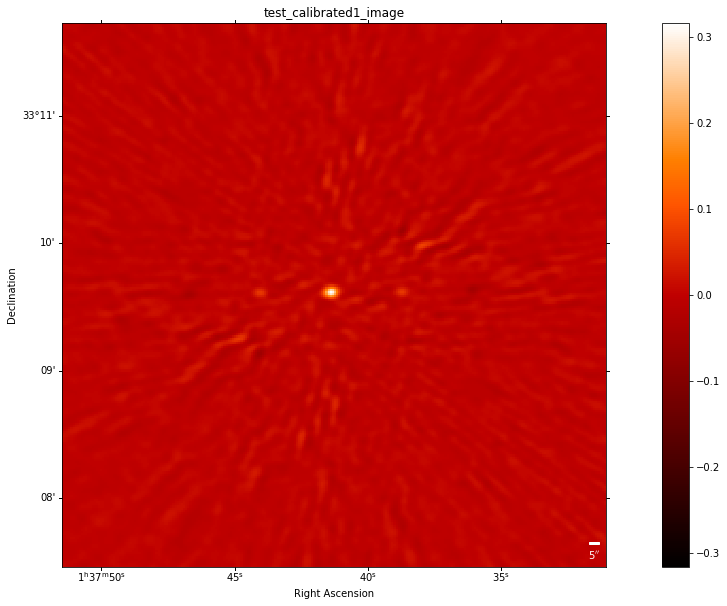

In [5]:
imagename='test_calibrated1_image'
# imview(raster={'file':f"{imagename}"+'.image', 'colormap': 'Hot Metal 1'}, 
#             out=f"{imagename}"+'_flagged'+'.cont'+'.png',
#           )


kwargs = {'kind':'plot'}
genpng(imagename+'.image',out=imagename, **kwargs)

In [4]:
plotms(vis='test_calibrated1.MS', yaxis='amp', xaxis='time',
       ydatacolumn='corrected',
#        xdatacolumn='corrected', 
#        avgtime='8', 
       antenna='C00', averagedata=True)

Qt: Session management error: None of the authentication protocols specified are supported


In [6]:
fitsfile = '/home/avi/CASA/imaging/data/TEST2505_B0329_100MHZ_GWB_2.FITS'

visfile ='test_uncalibrated.MS'
os.system(f'rm -rf {visfile}')
importgmrt(fitsfile=fitsfile, vis=visfile)

....10....20....30....40....50....60....70....80....90....100%
2022-03-09 06:57:42	WARN	MSFitsInput::fillAntennaTable	XYZHAND keyword not found in AN table. Will assume antenna coordinate system is right handed.
2022-03-09 06:57:49	WARN	importuvfits::::casa	*** Error 'local variable 'ok' referenced before assignment' updating HISTORY


In [3]:
visfile, calibrated_csource, calibrated_csource1,calibrated_csource2, imagename='test_uncalibrated.MS', 'test_cal.MS', 'test_cal1.MS','test_cal1.MS', 'test_cal2_image'
# rcal(visfile, calibrated_csource, calibrated_csource1, imagename)
outvis='test_flagged_bfc.MS'

In [ ]:
kwargs={'reset':True}

bandpass_fc(visfile, suffix='_init',ref_ant='C00', plotfolder='bp_plots/',fspw = '0:101~1900', 
                outvis=outvis, **kwargs)

2022-03-09 17:08:34	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.


Found no unflagged data at:   (time=2022/01/26/15:17:17.7 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2022/01/26/15:17:23.1 field=0 spw=0 chan=0)
5 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:17:28.5
6 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:17:33.8
6 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:17:39.2
5 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:17:44.6
6 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:17:49.9
5 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:17:55.3
5 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:18:00.7
5 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:18:06.0
6 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:18:11.4
6 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:18:16.8
5 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:18:22.2
5 of 60 solutio

5 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:27:08.3
7 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:27:13.7
15 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:27:19.0
15 of 60 solutions flagged due to SNR < 3 in spw=0 at 2022/01/26/15:27:24.4
47 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=2047) at 2022/01/26/15:19:23.6
48 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=2046) at 2022/01/26/15:19:23.6
48 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=2045) at 2022/01/26/15:19:23.6
47 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=2044) at 2022/01/26/15:19:23.6
46 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=2043) at 2022/01/26/15:19:23.6
46 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=2042) at 2022/01/26/15:19:23.6
47 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=2041) at 2022/01/26/15:19:23.6
45 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=2040) at 2022/01/

39 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1934) at 2022/01/26/15:19:23.6
38 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1933) at 2022/01/26/15:19:23.6
38 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1932) at 2022/01/26/15:19:23.6
38 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1931) at 2022/01/26/15:19:23.6
38 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1930) at 2022/01/26/15:19:23.6
39 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1929) at 2022/01/26/15:19:23.6
39 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1928) at 2022/01/26/15:19:23.6
39 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1927) at 2022/01/26/15:19:23.6
39 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1926) at 2022/01/26/15:19:23.6
39 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1925) at 2022/01/26/15:19:23.6
38 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1924) at 2022/01/26/15:19:23.6
38 of 55 solutions fl

21 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1823) at 2022/01/26/15:19:23.6
19 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1822) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1821) at 2022/01/26/15:19:23.6
19 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1820) at 2022/01/26/15:19:23.6
18 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1819) at 2022/01/26/15:19:23.6
18 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1818) at 2022/01/26/15:19:23.6
18 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1817) at 2022/01/26/15:19:23.6
18 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1816) at 2022/01/26/15:19:23.6
18 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1815) at 2022/01/26/15:19:23.6
18 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1814) at 2022/01/26/15:19:23.6
18 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1813) at 2022/01/26/15:19:23.6
18 of 55 solutions fl

11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1700) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1699) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1698) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1697) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1696) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1695) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1694) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1693) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1692) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1691) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1690) at 2022/01/26/15:19:23.6
10 of 55 solutions fl

12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1604) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1603) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1602) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1601) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1600) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1599) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1598) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1597) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1596) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1595) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1594) at 2022/01/26/15:19:23.6
11 of 55 solutions fl

11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1508) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1507) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1506) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1505) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1504) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1503) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1502) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1501) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1500) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1499) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1498) at 2022/01/26/15:19:23.6
11 of 55 solutions fl

12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1386) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1385) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1384) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1383) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1382) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1381) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1380) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1379) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1378) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1377) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1376) at 2022/01/26/15:19:23.6
11 of 55 solutions fl

11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1291) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1290) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1289) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1288) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1287) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1286) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1285) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1284) at 2022/01/26/15:19:23.6
10 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1283) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1282) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1281) at 2022/01/26/15:19:23.6
11 of 55 solutions fl

12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1175) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1174) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1173) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1172) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1171) at 2022/01/26/15:19:23.6
13 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1170) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1169) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1168) at 2022/01/26/15:19:23.6
13 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1167) at 2022/01/26/15:19:23.6
13 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1166) at 2022/01/26/15:19:23.6
13 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1165) at 2022/01/26/15:19:23.6
13 of 55 solutions fl

13 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1069) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1068) at 2022/01/26/15:19:23.6
11 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1067) at 2022/01/26/15:19:23.6
8 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1066) at 2022/01/26/15:19:23.6
9 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1065) at 2022/01/26/15:19:23.6
7 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1064) at 2022/01/26/15:19:23.6
7 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1063) at 2022/01/26/15:19:23.6
7 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1062) at 2022/01/26/15:19:23.6
8 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1061) at 2022/01/26/15:19:23.6
8 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1060) at 2022/01/26/15:19:23.6
8 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=1059) at 2022/01/26/15:19:23.6
8 of 55 solutions flagged due

15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=969) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=968) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=967) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=966) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=965) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=964) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=963) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=962) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=961) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=960) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=959) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due t

16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=854) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=853) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=852) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=851) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=850) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=849) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=848) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=847) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=846) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=845) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=844) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due t

16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=731) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=730) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=729) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=728) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=727) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=726) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=725) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=724) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=723) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=722) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=721) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due t

17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=630) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=629) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=628) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=627) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=626) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=625) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=624) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=623) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=622) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=621) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=620) at 2022/01/26/15:19:23.6
17 of 55 solutions flagged due t

12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=509) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=508) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=507) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=506) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=505) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=504) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=503) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=502) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=501) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=500) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=499) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due t

12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=385) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=384) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=383) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=382) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=381) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=380) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=379) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=378) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=377) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=376) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=375) at 2022/01/26/15:19:23.6
12 of 55 solutions flagged due t

14 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=289) at 2022/01/26/15:19:23.6
14 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=288) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=287) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=286) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=285) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=284) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=283) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=282) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=281) at 2022/01/26/15:19:23.6
16 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=280) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=279) at 2022/01/26/15:19:23.6
15 of 55 solutions flagged due t

20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=173) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=172) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=171) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=170) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=169) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=168) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=167) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=166) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=165) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=164) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=163) at 2022/01/26/15:19:23.6
20 of 55 solutions flagged due t

51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=54) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=53) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=52) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=51) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=50) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=49) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=48) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=47) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=46) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=45) at 2022/01/26/15:19:23.6
50 of 55 solutions flagged due to SNR < 10 in spw=0 (chan=44) at 2022/01/26/15:19:23.6
51 of 55 solutions flagged due to SNR < 10 

In [10]:
plotms(vis=visfile, yaxis='amp', xaxis='time',
       ydatacolumn='corrected',
#        xdatacolumn='corrected', 
#        avgtime='8', 
       antenna='C00', averagedata=True)

2022-03-11 09:10:54	SEVERE	plotms::::casa	Task plotms raised an exception of class RuntimeError with the following message: Input file not found:
2022-03-11 09:10:54	SEVERE	plotms::::casa+	/mnt/059D0C99140907FB/Physics/SETI/imaging/uGMRT/Pipeline/test_uncalibrated.MS


RuntimeError: Input file not found:
/mnt/059D0C99140907FB/Physics/SETI/imaging/uGMRT/Pipeline/test_uncalibrated.MS

In [ ]:
split(calibrated_csource1, calibrated_csource2)
def clean_oncal(calibrated_csource, imagename, **kwargs)
    suffix='_flagged'
    tclean(vis=calibrated_csource, 
           datacolumn='data', 
           imagename=imagename, 
           spw=goodchans, 
           specmode='mfs', 
           niter=100, 
           threshold='1.5Jy', 
           imsize=[256,256], cell='1arcsec', 
           weighting='briggs', robust=0.2, 
#            savemodel='modelcolumn'
          )
clean_oncal(calibrated_csource2, imagename, )
genpng(imagename+'.image', **kwargs)

caltable = Denisova:/home/avi/CASA/imaging/uGMRT/Pipeline/test_cal1.B_recal
This dataset (test_cal1.MS) does not have a BBC_NO column in the SPECTRAL_WINDOW_TABLE.
('spwsToPlot = ', array([0]))


2022-03-10 04:17:40	SEVERE	msmetadata_cmpt.cc::baseband	Exception Reported: This MS's SPECTRAL_WINDOW table does not have a BBC_NO column


()

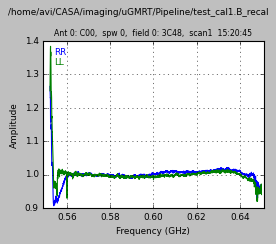

In [14]:
from casatasks import plotbandpass
plotbandpass(caltable='/home/avi/CASA/imaging/uGMRT/Pipeline/test_cal1.B_recal', xaxis='freq', yaxis='amp', field='0', antenna='C00')